# LSTM Prediction

In [1]:
import numpy as np

import collections
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from keras.utils import to_categorical

from matplotlib import pyplot as plt

import time

import os

import rasterio as r

from tqdm.notebook import tqdm

In [2]:
# ===========================================
# defining model
input_dim = 7
units = 20
output_size = 6

# Build the RNN model
def build_model(allow_cudnn_kernel=True, model_id=''):
    # CuDNN is only available at the layer level, and not at the cell level.
    # This means `LSTM(units)` will use the CuDNN kernel,
    # while RNN(LSTMCell(units)) will run on non-CuDNN kernel.
    if allow_cudnn_kernel:
        # The LSTM layer with default options uses CuDNN.
        lstm_layer1 = tf.keras.layers.LSTM(units, return_sequences=False, input_shape=(None, input_dim))
        lstm_layer2 = tf.keras.layers.LSTM(units*2, return_sequences=True, input_shape=(None, input_dim))
        lstm_layer3 = tf.keras.layers.LSTM(units*3, return_sequences=True, input_shape=(None, input_dim))
        lstm_layer4 = tf.keras.layers.LSTM(units*4, return_sequences=True, input_shape=(None, input_dim))
        lstm_layer5 = tf.keras.layers.LSTM(units*5, return_sequences=True, input_shape=(None, input_dim))
    else:
        # Wrapping a LSTMCell in a RNN layer will not use CuDNN.
        lstm_layer1 = tf.keras.layers.RNN(
            tf.keras.layers.LSTMCell(units, return_sequences=False),
            input_shape=(None, input_dim))
        lstm_layer2 = tf.keras.layers.RNN(
            tf.keras.layers.LSTMCell(units*2, return_Seuqences=True),
            input_shape=(None, input_dim))
        lstm_layer3 = tf.keras.layers.RNN(
            tf.keras.layers.LSTMCell(units*3, return_Seuqences=True),
            input_shape=(None, input_dim))
        lstm_layer4 = tf.keras.layers.RNN(
            tf.keras.layers.LSTMCell(units*4, return_Seuqences=True),
            input_shape=(None, input_dim))
        lstm_layer5 = tf.keras.layers.RNN(
            tf.keras.layers.LSTMCell(units*5, return_Seuqences=True),
            input_shape=(None, input_dim))

    # the model
    if model_id == 'model_1':
        model = tf.keras.models.Sequential([lstm_layer1, 
                                            tf.keras.layers.BatchNormalization(),
                                            tf.keras.layers.Dense(output_size, activation='softmax')])
    elif model_id == 'model_2':
        model = tf.keras.models.Sequential([lstm_layer2, 
                                            tf.keras.layers.BatchNormalization(),
                                            lstm_layer1, 
                                            tf.keras.layers.BatchNormalization(),
                                            tf.keras.layers.Dense(output_size, activation='softmax')])
    elif model_id == 'model_3':
        model = tf.keras.models.Sequential([lstm_layer3, 
                                            tf.keras.layers.BatchNormalization(),
                                            lstm_layer2, 
                                            tf.keras.layers.BatchNormalization(),
                                            lstm_layer1, 
                                            tf.keras.layers.BatchNormalization(),
                                            tf.keras.layers.Dense(output_size, activation='softmax')])
    elif model_id == 'model_4':
        model = tf.keras.models.Sequential([lstm_layer4, 
                                            tf.keras.layers.BatchNormalization(),
                                            lstm_layer3, 
                                            tf.keras.layers.BatchNormalization(),
                                            lstm_layer2, 
                                            tf.keras.layers.BatchNormalization(),
                                            lstm_layer1, 
                                            tf.keras.layers.BatchNormalization(),
                                            tf.keras.layers.Dense(output_size, activation='softmax')])
    elif model_id == 'model_5':
        model = tf.keras.models.Sequential([lstm_layer5, 
                                            tf.keras.layers.BatchNormalization(),
                                            lstm_layer4, 
                                            tf.keras.layers.BatchNormalization(),
                                            lstm_layer3, 
                                            tf.keras.layers.BatchNormalization(),
                                            lstm_layer2, 
                                            tf.keras.layers.BatchNormalization(),
                                            lstm_layer1, 
                                            tf.keras.layers.BatchNormalization(),
                                            tf.keras.layers.Dense(output_size, activation='softmax')])

    return model

In [3]:
model = build_model(allow_cudnn_kernel=True, model_id='model_3')
model.load_weights('/home/bruno.matosak/GEOINFO 2021/Pantanal/Landsat SR all/LSTM trainings/models/model_3/filled/001.h5')
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, None, 60)          16320     
_________________________________________________________________
batch_normalization (BatchNo (None, None, 60)          240       
_________________________________________________________________
lstm_1 (LSTM)                (None, None, 40)          16160     
_________________________________________________________________
batch_normalization_1 (Batch (None, None, 40)          160       
_________________________________________________________________
lstm (LSTM)                  (None, 20)                4880      
_________________________________________________________________
batch_normalization_2 (Batch (None, 20)                80        
_________________________________________________________________
dense (Dense)                (None, 6)                 1

In [4]:
cube_0 = r.open('/home/bruno.matosak/GEOINFO 2021/Pantanal/Landsat SR all/cubes/band1_filled.tif')
result = np.zeros([cube_0.height, cube_0.width], dtype=np.int)

bands = ['band1', 'band2', 'band3', 'band4', 'band5', 'band6', 'band7']
cubes_path = '/home/bruno.matosak/GEOINFO 2021/Pantanal/Landsat SR all/cubes/{0}_filled.tif'

series = np.zeros([cube_0.width, cube_0.count, len(bands)], dtype=np.float32)
for i in tqdm(range(cube_0.height)):
    for j in range(len(bands)):
        series[:,:,j] = np.moveaxis(r.open(cubes_path.format(bands[j])).read(window=r.windows.Window(0,i,cube_0.width,1)).squeeze(), 0,-1)/10000
        
    pred = tf.argmax(model.predict(series, verbose=0), axis=1)
    result[i,:] = pred

## Plotting Result

In [5]:
# custom cmap
from matplotlib.colors import ListedColormap

col_dict = ['#000000', # no data
            '#668cff', # água
            '#008040', # Floresta
            '#00ff80', # Formação Natural Não Florestal
            '#ffffb3', # Agropecuária
            '#ff3385'] # Área não vegetada

cmap = ListedColormap(col_dict)

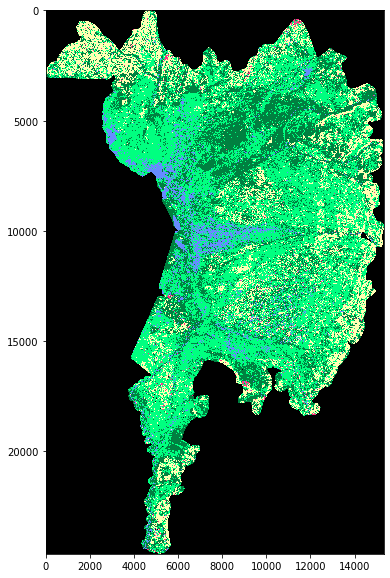

In [6]:
plt.figure(figsize=(10,10))
plt.imshow(result, cmap=cmap, interpolation='nearest')
plt.show()

## Saving Result

In [7]:
import gdal

ref = gdal.Open('/home/bruno.matosak/GEOINFO 2021/Pantanal/Landsat SR all/cubes/pixel_qa.tif')
in_band = ref.GetRasterBand(1)

gtiff_driver = gdal.GetDriverByName('GTiff')
path_result = '/home/bruno.matosak/GEOINFO 2021/Pantanal/Landsat SR all/LSTM trainings/result/Pantanal-LSTM-model_3-filled-001.tif'
out_ds = gtiff_driver.Create(path_result, result.shape[1], result.shape[0], 1, in_band.DataType, ['COMPRESS=LZW'])
out_ds.SetProjection(ref.GetProjection())
out_ds.SetGeoTransform(ref.GetGeoTransform())  

band = out_ds.GetRasterBand(1)
band.WriteArray(result)
band.SetNoDataValue(0)
band.FlushCache()

out_ds = None
ref = None

print(path_result)

/home/bruno.matosak/GEOINFO 2021/Pantanal/Landsat SR all/LSTM trainings/result/Pantanal-LSTM-model_3-filled-001.tif
